In [1]:

import random, math, time
import matplotlib.pyplot as plt
import numpy as np
import heapq
import csv
from collections import defaultdict, deque

random.seed(30)
np.random.seed(30)


In [2]:
NUMS_NODE = 20
NODES = [chr(ord('A') + i) for i in range(NUMS_NODE)]
EDGE_COUNT = random.randint(20, 25)
edges = set()

while len(edges) < EDGE_COUNT:
    v_from, v_to = random.sample(NODES, 2)
    if (v_from, v_to) not in edges and (v_to, v_from) not in edges:
        weight = random.randint(1, 20)
        edges.add((v_from, v_to, weight))

print(f"Tổng số đỉnh: {len(NODES)} | Số cạnh: {len(edges)}")
list(edges)[:5]

with open("edges.csv", "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f, delimiter=",")
        writer.writerow(["v_from", "v_to", "weight"])     # header cố định
        for v_from, v_to, weight in edges:
            writer.writerow([v_from, v_to, weight])


Tổng số đỉnh: 20 | Số cạnh: 24


In [3]:


class Graph:
    """
    Đồ thị vô hướng có trọng số (adjacency list) + layout hình tròn để trực quan.

    Chức năng chính
    ---------------
    - Xây dựng đồ thị từ danh sách cạnh `edges = [(u, v, w), ...]`.
    - Cung cấp láng giềng qua `neighbors(node)`.
    - Tự gán toạ độ (x, y) cho mỗi đỉnh theo vòng tròn để dễ vẽ.
    - Vẽ đồ thị với tuỳ chọn: đánh dấu đường đi `path`, `start`, `goal`.

    Thuộc tính
    ----------
    adj : Dict[Node, List[Tuple[Node, float]]]
        Danh sách kề: mỗi node ánh xạ đến danh sách (hàng xóm, trọng số).
    positions : Dict[Node, Tuple[float, float]]
        Toạ độ (x, y) của từng node dùng cho việc vẽ.
    edge_list : List[Edge]
        Bản sao danh sách cạnh đầu vào (để tiện tra cứu/hiển thị).
    """
    def __init__(self, edges):
        self.adj = defaultdict(list)
        self.positions = {}
        self.edge_list = list(edges)
        self._build_graph(edges)

    def _build_graph(self, edges):
        """
        Xây dựng adjacency list và layout hình tròn cho các đỉnh.

        - Thêm mỗi cạnh (u, v, w) vào cả hai chiều (đồ thị vô hướng).
        - Tính toạ độ các đỉnh theo vòng tròn: đều góc, bán kính = 1.
        """
        # Xây dựng danh sách kề
        for v_from, v_to, weight in edges:
            self.add_edge(v_from, v_to, weight)

        # Chuẩn bị danh sách đỉnh và gán layout hình tròn
        nodes = sorted({v_from for v_from, _, _ in edges} | {v_to for _, v_to, _ in edges})

        # --- Xây layout kiểu neural net (từ trái qua phải) ---
        # Ý tưởng: Start (A) ở cột đầu, Goal ở cột cuối, các node khác chia lớp giữa
        layers = []
        visited = set()
        current_layer = ["A"]
        while current_layer:
            layers.append(current_layer)
            next_layer = []
            for node in current_layer:
                for neighbor, _ in self.adj[node]:
                    if neighbor not in visited and neighbor not in current_layer:
                        next_layer.append(neighbor)
                visited.add(node)
            current_layer = list(set(next_layer))
        # --- Gán toạ độ ---
        self.positions = {}
        for i, layer in enumerate(layers):
            y_spacing = 1.0 / (len(layer) + 1)
            for j, node in enumerate(sorted(layer)):
                self.positions[node] = (i, 1 - (j + 1) * y_spacing)

    def add_edge(self, v_from, v_to, weight):
        """
        Thêm cạnh vô hướng (u, v) có trọng số w vào đồ thị.
        """
        self.adj[v_from].append((v_to, weight))
        self.adj[v_to].append((v_from, weight))

    def neighbors(self, node):
        """
        Trả về danh sách láng giềng của `node` dạng [(hàng_xóm, trọng_số), ...].
        """
        return self.adj[node]

    def plot(self, path=None, start=None, goal=None, title="Graph"):
        """
        Vẽ đồ thị với layout hình tròn; hiển thị trọng số trên mỗi cạnh.
        - Nếu `path` được cung cấp (danh sách đỉnh theo thứ tự), vẽ đường đi màu đỏ.
        - Đỉnh `start` màu xanh lá, `goal` màu vàng.

        Parameters
        ----------
        path : Optional[List[Node]]
            Đường đi (chuỗi node) để highlight.
        start, goal : Optional[Node]
            Các đỉnh đặc biệt để đánh dấu.
        title : str
            Tiêu đề biểu đồ.
        """
        plt.figure(figsize=(14, 7))

        # --- Vẽ các cạnh ---
        for v_from in self.adj:
            for v_to, weight in self.adj[v_from]:
                if v_from < v_to:
                    # Lấy toạ độ hai đầu mút
                    x1, y1 = self.positions[v_from]
                    x2, y2 = self.positions[v_to]

                    # Vẽ cạnh màu xám nhạt
                    plt.plot([x1,x2],[y1,y2],color='gray',alpha=0.5)

                    # Vẽ trọng số w ở trung điểm cạnh
                    xm, ym=(x1+x2)/2,(y1+y2)/2
                    plt.text(xm,ym,str(weight),fontsize=8,color='black')

        # --- Vẽ đường đi ---
        if path:
            for i in range(len(path)-1):
                v_from,v_to=path[i],path[i+1]
                x1,y1=self.positions[v_from]
                x2,y2=self.positions[v_to]

                # Đường đi tô đậm màu đỏ
                plt.plot([x1,x2],[y1,y2],color='red',linewidth=2.5)

        # --- Vẽ các đỉnh ---
        # Để tránh trùng legend, chỉ gắn label lần đầu
        labeled = {"Start": False, "Goal": False}
        for node,(x,y) in self.positions.items():
            if node==start:
                plt.scatter(x,y,color='green',s=300,label='Start')
                labeled["Start"] = True
            elif node==goal:
                plt.scatter(x,y,color='gold',s=300,label='Goal')
                labeled["Goal"] = True
            else:
                plt.scatter(x,y,color='skyblue',s=250)

            # Hiển thị nhãn node ở vị trí của nó
            plt.text(x,y,node,fontsize=12,ha='center',va='center')

        plt.title(title)
        # Hiện legend nếu có start/goal
        if any(labeled.values()):
            plt.legend()
        plt.axis('off')
        plt.show()


In [4]:
def import_graph_from_edges_csv(csv_path: str, *, encoding: str = "utf-8", delimiter: str = ","):
    """
    Đọc file CSV 'v_from,v_to,weight' và trả về (graph, edges_list).

    Parameters
    ----------
    csv_path : str
        Đường dẫn file CSV chứa cạnh với header 'u,v,w'.
    encoding : str, optional
        Bảng mã, mặc định "utf-8".
    delimiter : str, optional
        Ký tự phân tách cột CSV, mặc định ",".

    Returns
    -------
    graph : Graph
        Đồ thị được dựng từ danh sách cạnh.
    edges_list : List[Edge]
        Danh sách cạnh [(v_from, v_to, weight), ...] đọc từ CSV.
    """
    edges_list = []
    with open(csv_path, "r", encoding=encoding, newline="") as f:
        reader = csv.reader(f, delimiter=delimiter)
        header = next(reader, None)
        if not header or [h.strip().lower() for h in header] != ["v_from", "v_to", "weight"]:
            raise ValueError(f"CSV phải có header 'v_from,v_to,weight' (tìm thấy: {header})")
        for row in reader:
            if not row:
                continue
            v_from, v_to, weight = row[0].strip(), row[1].strip(), float(row[2].strip())
            edges_list.append((v_from, v_to, weight))

    # Dựng Graph theo cấu trúc sẵn có (Graph tự gán positions hình tròn)
    g = Graph(edges_list)
    return g, edges_list

In [5]:

def dijkstra(graph, start, goal):
    """
    Dijkstra ngắn nhất đường đi trên đồ thị có trọng số không âm (vô hướng hoặc có hướng).

    Thuật toán
    ---------
    - Dùng hàng đợi ưu tiên (min-heap) `frontier` lưu cặp (cost_tích_lũy, node).
    - Mỗi lần lấy node có cost nhỏ nhất ra để mở rộng (relax cạnh).
    - Bảng `dist` giữ chi phí tốt nhất đã biết đến mỗi node.
    - Bảng `prev` để lần vết đường đi tối ưu sau khi kết thúc.

    Yêu cầu
    -------
    - `graph.neighbors(v_from)` trả danh sách các cặp `(v_to, weight)` với `v_to` là hàng xóm của `v_from`
      và `weight >= 0` là trọng số cạnh (v_from→v_to). Trọng số **không âm** là điều kiện cần cho Dijkstra.

    Parameters
    ----------
    graph : object
        Đối tượng đồ thị cung cấp phương thức `neighbors(node) -> Iterable[Tuple[node, weight]]`.
    start : Hashable
        Đỉnh xuất phát.
    goal : Hashable
        Đỉnh đích.

    Returns
    -------
    result : Dict[str, Any]
        {
          'name'    : 'Dijkstra',
          'path'    : List[node],          # đường đi tối ưu từ start đến goal (rỗng nếu không tới được)
          'cost'    : float,               # chi phí tối ưu (∞ nếu không tới được)
          'expanded': int,                 # số node pop ra từ heap (mở rộng)
          'time_ms' : float                # thời gian chạy (milliseconds)
        }

    Notes
    -----
    - Độ phức tạp: O((V + E) log V) với triển khai heap tiêu chuẩn (trong code này là
      “đẩy thêm vào heap khi cải thiện”, thay vì decrease-key).
    - Nếu `goal` không đạt tới, `path` sẽ vẫn chứa `goal` một mình ở cuối vòng dựng path
      **nếu** goal chưa từng thấy. Ở đây ta dùng `prev.get(node)` nên đường đi sẽ chỉ là [goal]
      trước khi đảo chiều — có thể tuỳ biến để trả `[]` nếu muốn.
    """
    # Min-heap ưu tiên theo chi phí tích lũy
    frontier=[(0,start)]

    # Khoảng cách tốt nhất đã biết đến mỗi node; khởi tạo start = 0
    dist={start:0}

    # Bảng truy vết: prev[v_to] = v_from nghĩa là tối ưu hiện có đi tới v_to thông qua v_from
    prev={start:None}

    expansions=0
    t0=time.time()

    # Vòng chính: mỗi lần lấy node có chi phí nhỏ nhất ra để mở rộng
    while frontier:
        cost,node=heapq.heappop(frontier)
        if cost > dist.get(node, float('inf')):
            continue  # skip stale

        expansions+=1

        # Nếu đã tới goal thì dừng
        if node==goal:
            break

        # Relax tất cả cạnh (node -> neigh) với trọng số weight
        for neigh,w in graph.neighbors(node):
            new_cost=cost+w

            # Nếu tìm thấy đường tốt hơn đến neigh, cập nhật và đẩy vào heap
            if new_cost<dist.get(neigh,float('inf')):
                dist[neigh]=new_cost
                prev[neigh]=node
                heapq.heappush(frontier,(new_cost,neigh))

    if dist.get(goal, float('inf')) == float('inf'):
        return {'name':'Dijkstra','path':[],'cost':float('inf'),'expanded':expansions,'time_ms':(time.time()-t0)*1000}

    # Lần vết đường đi từ goal về start thông qua prev
    path=[]
    node=goal
    while node is not None:
        path.append(node)
        node=prev.get(node) # trả None nếu chưa từng ghé node
    path.reverse()

    # Nếu goal không đạt tới, dist[goal] sẽ là inf
    t_ms=(time.time()-t0)*1000
    return {'name':'Dijkstra',
            'path':path,
            'cost':dist.get(goal,float('inf')),
            'expanded':expansions,
            'time_ms':t_ms}


In [6]:

def heuristic(a,b,positions):
    """
    Heuristic Euclid giữa hai đỉnh a, b dựa trên toạ độ đã gán trong `positions`.

    Parameters
    ----------
    a, b : Hashable
        Nhãn/ID của hai đỉnh trong đồ thị.
    positions : Dict[Hashable, Tuple[float, float]]
        Bảng tra toạ độ (x, y) của từng đỉnh, ví dụ: graph.positions.

    Returns
    -------
    float
        Khoảng cách Euclid giữa a và b (dùng `math.dist`).

    Notes
    -----
    - Heuristic này admissible nếu trọng số cạnh gần với quãng đường hình học,
      và consistent khi metric phù hợp với chi phí thật của đồ thị.
    """
    (x1,y1),(x2,y2)=positions[a],positions[b]
    return math.dist((x1,y1),(x2,y2))

def astar(graph,start,goal):
    """
    A* tìm đường đi chi phí nhỏ nhất từ `start` đến `goal` trên đồ thị có trọng số không âm.

    Thuật toán (tóm tắt)
    --------------------
    - Duy trì:
      * `g[n]`: chi phí tốt nhất đã biết từ start -> n.
      * `f[n] = g[n] + heuristic(n, goal)`.
      * `frontier`: min-heap ưu tiên theo f-score.
      * `prev[n]`: cha của n trong đường đi tối ưu hiện có (để reconstruct).
    - Mỗi vòng lặp: pop node có f nhỏ nhất; nếu là goal thì dừng.
      Relax các cạnh từ node sang láng giềng và cập nhật g/f/prev nếu cải thiện.

    Yêu cầu `graph`
    ---------------
    - `graph.neighbors(u)` trả Iterable[(v, w)] với w >= 0 (trọng số không âm).
    - `graph.positions` là dict: node -> (x, y), để tính heuristic Euclid.

    Returns
    -------
    dict
        {
          'name'    : 'A*',
          'path'    : list các đỉnh từ start đến goal (có thể rỗng tuỳ tình huống),
          'cost'    : g[goal] nếu có đường, ngược lại là inf,
          'expanded': số node đã pop khỏi heap (mở rộng),
          'time_ms' : thời gian chạy (milliseconds)
        }

    Notes
    -----
    - Hàm giữ nguyên hành vi gốc: nếu goal không reachable, `path` sẽ vẫn chứa
      chỉ `goal` trước khi bạn kiểm tra cost (có thể là inf). Nếu muốn, bạn có
      thể đổi trả `[]` khi `g.get(goal, inf) == inf`.
    """

    # Min-heap các cặp (f-score, node). Khởi tạo f[start] = heuristic(start, goal).
    frontier=[(0,start)]
    g={start:0}
    f={start:heuristic(start,goal,graph.positions)}
    prev={start:None}

    expansions=0
    t0=time.time()

    while frontier:
        # Lấy node có f nhỏ nhất (nhờ heapq).
        _,node=heapq.heappop(frontier)
        expansions+=1

        # Nếu đã tới goal: dừng sớm (A* bảo đảm tối ưu khi heuristic admissible/consistent).
        if node==goal:
            break

        # Relax tất cả láng giềng
        for neigh,w in graph.neighbors(node):
            g_new=g[node]+w # chi phí mới qua node
            # Nếu tìm được đường tốt hơn đến neigh, cập nhật và đẩy vào heap
            if g_new<g.get(neigh,float('inf')):
                g[neigh]=g_new
                f[neigh]=g_new+heuristic(neigh,goal,graph.positions)
                prev[neigh]=node
                heapq.heappush(frontier,(f[neigh],neigh))

    # Lần vết đường đi từ goal về start thông qua prev
    path=[]
    node=goal
    while node is not None:
        path.append(node)
        node=prev.get(node)
    path.reverse()

    t_ms=(time.time()-t0)*1000

    return {'name':'A*',
            'path':path,
            'cost':g.get(goal,float('inf')),
            'expanded':expansions,
            'time_ms':t_ms}


In [7]:

def bfs(graph,start,goal):
    """
    BFS (Breadth-First Search) trên đồ thị để tìm đường đi từ `start` đến `goal`.

    Đặc điểm
    --------
    - Duyệt theo **lớp** (FIFO queue), bảo đảm độ dài đường đi (số cạnh) là nhỏ nhất
      trong **đồ thị không trọng số**.
    - Với đồ thị **có trọng số**, BFS **không tối ưu chi phí**; ở đây vẫn tính
      `cost` bằng cách cộng trọng số theo đường tìm được (không đảm bảo nhỏ nhất).

    Yêu cầu `graph`
    ---------------
    - Có phương thức `neighbors(u)` trả Iterable[(v, w)] với v là hàng xóm và w là trọng số cạnh.

    Trả về
    ------
    dict: {
      'name'    : 'BFS',
      'path'    : danh sách đỉnh từ start→goal (rỗng nếu không tới được),
      'cost'    : tổng trọng số đường đi tìm được,
      'expanded': số đỉnh đã được lấy ra khỏi queue (mở rộng),
      'time_ms' : thời gian chạy (ms)
    }
    """
    q=deque([start])  # hàng đợi duyệt theo lớp
    prev={start:None} # truy vết cha: prev[v] = u
    visited={start}   # tập đã thăm, tránh lặp
    expansions=0
    t0=time.time()

    # Vòng lặp BFS chuẩn: pop-left, kiểm goal, đẩy hàng xóm chưa thăm
    while q:
        node=q.popleft()
        expansions+=1
        if node==goal: break
        for neigh,_ in graph.neighbors(node):
            if neigh not in visited:
                visited.add(neigh)
                prev[neigh]=node
                q.append(neigh)

    # Lần vết đường đi từ goal về start theo prev
    path=[]
    node=goal
    while node is not None:
        path.append(node)
        node=prev.get(node)
    path.reverse()

    # Tính chi phí (cộng trọng số các cạnh trên path)
    # Lưu ý: BFS không tối ưu chi phí với đồ thị có trọng số.
    cost=0
    for i in range(len(path)-1):
        for v,w in graph.neighbors(path[i]):
            if v==path[i+1]: cost+=w
    t_ms=(time.time()-t0)*1000
    return {'name':'BFS',
            'path':path,
            'cost':cost,
            'expanded':expansions,
            'time_ms':t_ms}

def dfs(graph,start,goal):
    """
    DFS (Depth-First Search) để tìm **một** đường đi từ `start` đến `goal`.

    Đặc điểm
    --------
    - Duyệt theo **chiều sâu** (LIFO stack), có thể đạt goal nhanh trên thực tế,
      nhưng **không tối ưu** cả về độ dài lẫn chi phí, và phụ thuộc thứ tự láng giềng.
    - Với đồ thị có chu trình, dùng `visited` để tránh lặp vô tận.

    Yêu cầu `graph`
    ---------------
    - Có phương thức `neighbors(u)` trả Iterable[(v, w)].

    Trả về
    ------
    dict: {
      'name'    : 'DFS',
      'path'    : danh sách đỉnh từ start→goal (rỗng nếu không tới được),
      'cost'    : tổng trọng số theo đường DFS tìm được,
      'expanded': số đỉnh đã pop khỏi stack (mở rộng),
      'time_ms' : thời gian chạy (ms)
    }
    """
    stack=[start]     # ngăn xếp LIFO
    prev={start:None} # truy vết cha
    visited={start}   # đã thăm
    expansions=0
    t0=time.time()

    # Vòng lặp DFS chuẩn: pop, kiểm goal, đẩy hàng xóm chưa thăm
    while stack:
        node=stack.pop()
        expansions+=1
        if node==goal: break
        for neigh,_ in graph.neighbors(node):
            if neigh not in visited:
                visited.add(neigh)
                prev[neigh]=node
                stack.append(neigh)

    # Lần vết đường đi từ goal về start
    path=[]
    node=goal
    while node is not None:
        path.append(node)
        node=prev.get(node)
    path.reverse()

    # Tính chi phí đường đi DFS tìm được (không tối ưu chi phí)
    cost=0
    for i in range(len(path)-1):
        for v,w in graph.neighbors(path[i]):
            if v==path[i+1]: cost+=w

    t_ms=(time.time()-t0)*1000

    return {'name':'DFS',
            'path':path,
            'cost':cost,
            'expanded':expansions,
            'time_ms':t_ms}


Chạy và so sánh 4 thuật toán tìm đường trên đồ thị có trọng số:
- Dijkstra
- A* (heuristic Euclid dựa trên graph.positions)
- BFS  (không tối ưu chi phí trong đồ thị có trọng số)
- DFS  (không tối ưu, tìm một đường đi bất kỳ)

In kết quả từng thuật toán, vẽ đường đi của Dijkstra lên đồ thị,
và trực quan hoá các chỉ số: tổng chi phí, số node mở rộng, thời gian (ms).


Dijkstra | cost= 33.0 | expanded=  16 | time=0.06 ms | path=['A', 'D', 'P', 'T']
A*       | cost= 33.0 | expanded=  16 | time=0.06 ms | path=['A', 'D', 'P', 'T']
BFS      | cost= 33.0 | expanded=  17 | time=0.02 ms | path=['A', 'D', 'P', 'T']
DFS      | cost= 33.0 | expanded=   4 | time=0.01 ms | path=['A', 'D', 'P', 'T']


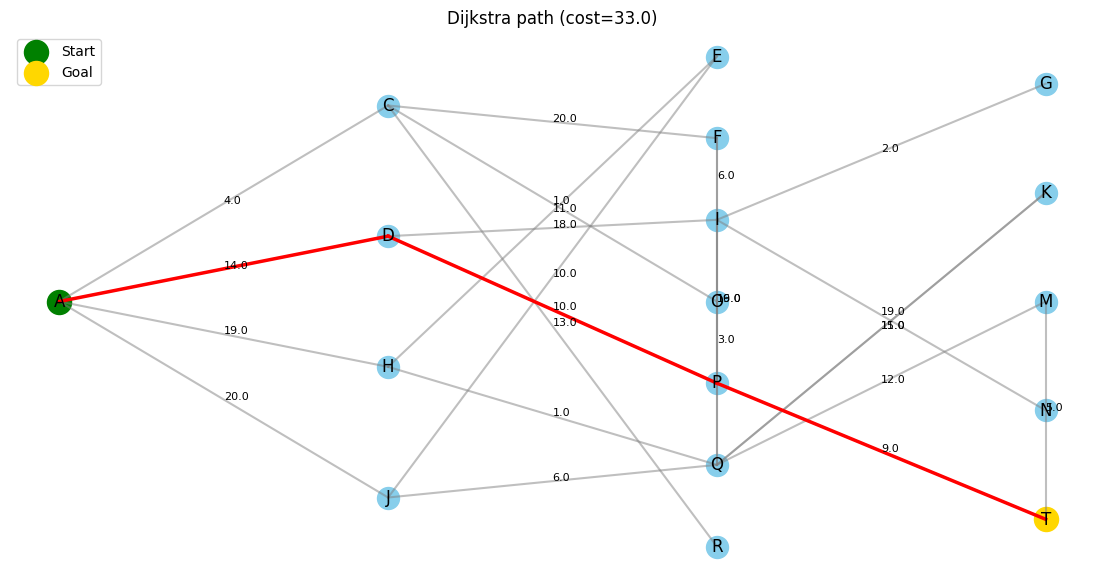

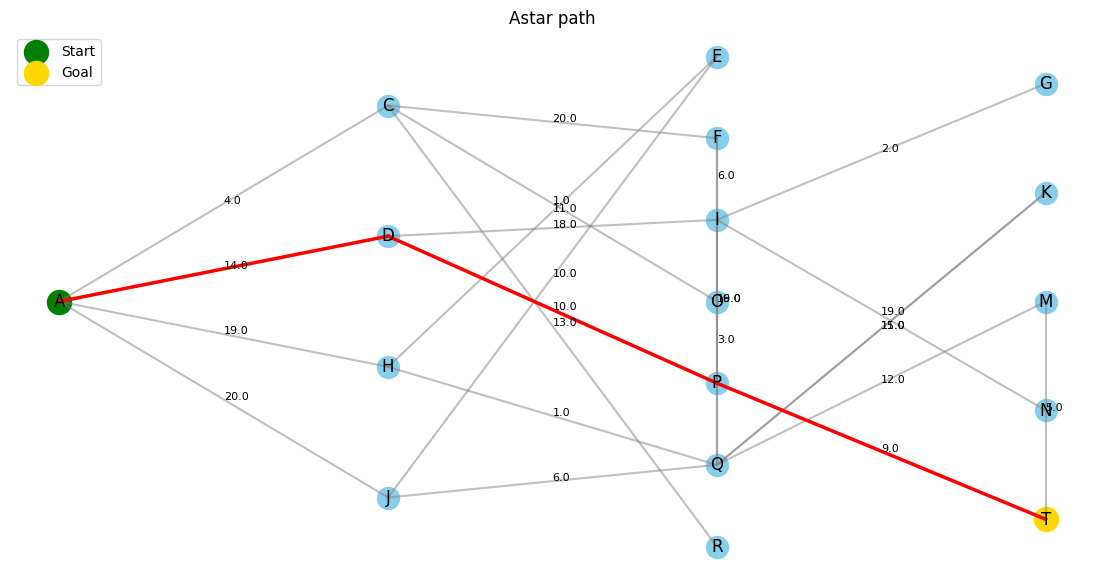

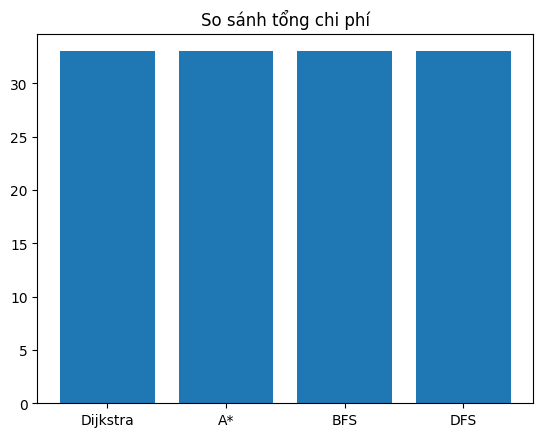

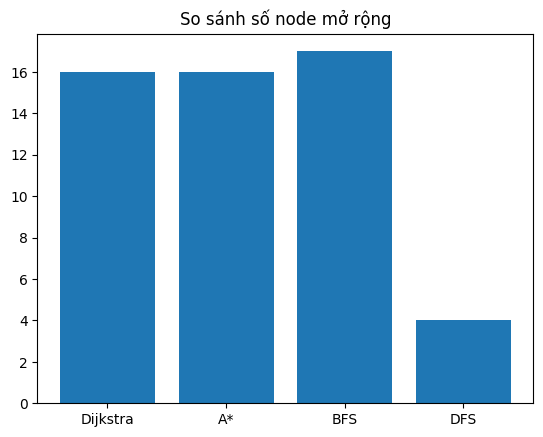

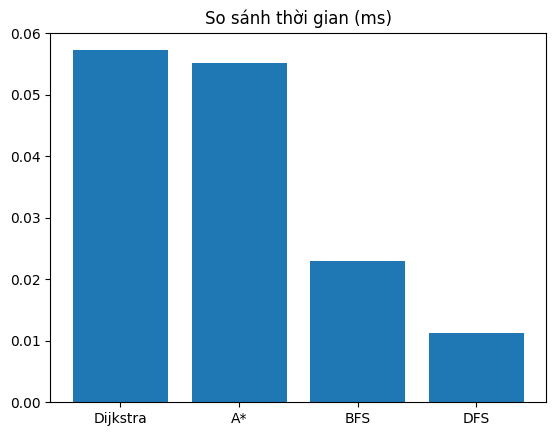

In [8]:

# Tạo đồ thị từ danh sách cạnh
g, edges_list_in = import_graph_from_edges_csv("edges.csv")

nodes = list(g.adj.keys())
start = "A"
goal = nodes[-1]

# Chạy lần lượt các thuật toán và gom kết quả
results=[]
for algo in [dijkstra,astar,bfs,dfs]:
    res=algo(g,start,goal)
    results.append(res)
    print(f"{res['name']:8s} | cost={res['cost']:>5} | expanded={res['expanded']:>4} | time={res['time_ms']:.2f} ms | path={res['path']}")

# Vẽ đường đi của Dijkstra
best=results[0]
g.plot(best['path'],start,goal,title=f"Dijkstra path (cost={best['cost']})")

# Vẽ đường đi của Astar
astar=results[1]
g.plot(astar['path'],start,goal,title=f"Astar path")

# Chuẩn bị dữ liệu cho các biểu đồ so sánh
labels=[r['name'] for r in results]
costs=[r['cost'] for r in results]
expanded=[r['expanded'] for r in results]
times=[r['time_ms'] for r in results]

# 6) Vẽ 3 biểu đồ so sánh: chi phí, số node mở rộng, thời gian
plt.figure(); plt.bar(labels,costs); plt.title("So sánh tổng chi phí"); plt.show()
plt.figure(); plt.bar(labels,expanded); plt.title("So sánh số node mở rộng"); plt.show()
plt.figure(); plt.bar(labels,times); plt.title("So sánh thời gian (ms)"); plt.show()
